# Neural Networks for Data Science Applications
## Lab session (extra): Recurrent neural networks

**Contents of the lab session:**
+ Recurrent neural networks in TensorFlow.
+ A simple example by implementing a counting algorithm.
+ A more elaborate encoder/decoder on a sorting problem.

In [1]:
# Remember to enable a GPU on Colab by:
# Runtime >> Change runtime type >> Hardware accelerator (before starting the VM).
!pip install -q tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 41kB/s 
     |████████████████████████████████| 3.8MB 51.3MB/s 
     |████████████████████████████████| 450kB 51.2MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.


In [0]:
import tensorflow as tf

### Example 1: counting with RNNs (fixed length)

To show how RNNs work, we consider a very simplified setup where we want to learn a counting algorithm:


1.   The RNN receives a sequence of symbols in input (each symbol represented with a one-hot encoding);
2.   We output a probability distribution on the most frequent symbol in the sequence.

For this first example, all sequences will have the same length.



In [0]:
n_max = 5            # How many symbols we consider
max_seq_len = 10     # Length for the sequence
units = 100          # Size of the RNN state vector

In [0]:
# In order to load data into TF, we first define a generator outputting random training sequences.
def gen_seq():
  while True: # The generator is infinite
    # First generate a random vector of integers in [0, n_max-1]
    x = tf.random.uniform(shape=(max_seq_len,), maxval=n_max, dtype=tf.int32)
    # Convert the vector to a one-hot representation for the symbols
    x = tf.one_hot(x, depth=n_max)
    # Get the symbol appearing most frequently
    y = tf.argmax(tf.reduce_sum(x, axis=0), axis=0)
    yield x, y

In [0]:
# Get one sequence
X, y = next(gen_seq())

In [6]:
print(X)
print(y)

tf.Tensor(
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]], shape=(10, 5), dtype=float32)
tf.Tensor(2, shape=(), dtype=int64)


In [0]:
# We load the sequences inside a tf.data.Dataset object
dataset = tf.data.Dataset.from_generator(lambda: gen_seq(), output_types=(tf.float32, tf.float32))

In [8]:
# Try batching!
for xb, yb in dataset.batch(3):
  print(xb.shape)
  print(yb.shape)
  break

(3, 10, 5)
(3,)


In [0]:
from tensorflow.keras import layers

In [0]:
# SimpleRNN corresponds to the basic RNN in the slides
rnn = layers.SimpleRNN(units)

In [0]:
# Initialize the state vector (note: one state for each sequence in the mini-batch)
init_state = tf.zeros(shape=(3, units))

In [0]:
# Run the RNN!
states = tf.identity(init_state)
for i in range(max_seq_len):
    states = rnn(xb[:, i:i+1, :], states)

In [13]:
states.shape

TensorShape([3, 100])

In [0]:
# Simplified notation: we can let the SimpleRNN object do the loop
states2 = rnn(xb, init_state)

In [0]:
tf.reduce_all(states == states2)

In [0]:
from tensorflow.keras import Sequential, losses, optimizers, metrics

In [0]:
# Define our model: 
# 1. The SimpleRNN computes the state update, returning the state vector after processing the entire sequence.
# 2. The Dense layer makes the final prediction (which symbol is most frequent) from the last state.
rnn_full = Sequential([
      layers.SimpleRNN(units, input_shape=(max_seq_len, n_max)),
      layers.Dense(n_max, activation='softmax')
])

In [0]:
rnn_full.compile(loss=losses.SparseCategoricalCrossentropy(), optimizer=optimizers.RMSprop(0.001), metrics=['accuracy'])

In [17]:
rnn_full.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               10600     
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 11,105
Trainable params: 11,105
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Note: because the generator is infinite, we can select manually the size of an epoch.
history = rnn_full.fit_generator(dataset.batch(32), steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 9s 86ms/step - loss: 0.7964 - accuracy: 0.7094
Epoch 2/10
100/100 [==============================] - 8s 85ms/step - loss: 0.4963 - accuracy: 0.8191
Epoch 3/10
100/100 [==============================] - 9s 87ms/step - loss: 0.3976 - accuracy: 0.8597
Epoch 4/10
100/100 [==============================] - 9s 86ms/step - loss: 0.3503 - accuracy: 0.8737
Epoch 5/10
100/100 [==============================] - 8s 85ms/step - loss: 0.2986 - accuracy: 0.8944
Epoch 6/10
100/100 [==============================] - 9s 86ms/step - loss: 0.2695 - accuracy: 0.9097
Epoch 7/10
100/100 [==============================] - 9s 86ms/step - loss: 0.2683 - accuracy: 0.9044
Epoch 8/10
100/100 [==============================] - 9s 86ms/step - loss: 0.2462 - accuracy: 0.9125
Epoch 9/10
100/100 [==============================] - 9s 86ms/step - loss: 0.2314 - accuracy: 0.9191
Epoch 10/10
100/100 [==============================] - 9s 86ms/step - loss: 0.2202 - accura

### Example 2: counting with RNNs (variable length)

This is the same example as before, but we let the sequences vary in length. This also shows an example of masking inside TensorFlow.

In [0]:
def gen_seq():
  while True:

    # This is the main modification: for each sequence, we sample a length uniformly in [1, max_seq_len-1]
    seq_len = tf.random.uniform(shape=(1,), minval=1, maxval=max_seq_len, dtype=tf.int32)

    x = tf.random.uniform(shape=(seq_len[0],), maxval=n_max, dtype=tf.int32)
    x = tf.cast(tf.one_hot(x, depth=n_max), tf.float32)
    y = tf.argmax(tf.reduce_sum(x, axis=1), axis=0)
    yield x, y

In [0]:
dataset = tf.data.Dataset.from_generator(lambda: gen_seq(), output_types=(tf.float32, tf.float32))

In [0]:
# Because the sequences vary in length, we need padding to make a batch.
# The first argument defines the size of the output tensors. We use -1.0 as padding, because 0
# is reserved for the first symbol in our encoding.
train_it = dataset.padded_batch(3, ([max_seq_len, n_max],[]), padding_values=(-1.0, -1.0))

In [22]:
# Check the result
for xb, yb in train_it:
  print(xb.shape)
  print(yb.shape)
  print(xb)
  print(yb)
  break

(3, 10, 5)
(3,)
tf.Tensor(
[[[ 0.  1.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.]
  [ 0.  1.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  1.]
  [ 0.  0.  1.  0.  0.]
  [ 0.  0.  0.  0.  1.]
  [ 1.  0.  0.  0.  0.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]]

 [[ 0.  1.  0.  0.  0.]
  [ 0.  0.  0.  0.  1.]
  [ 0.  0.  1.  0.  0.]
  [ 0.  0.  0.  1.  0.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]]

 [[ 0.  1.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.]
  [ 0.  1.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.]
  [ 1.  0.  0.  0.  0.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1.]]], shape=(3, 10, 5), dtype=float32)
tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)


In [0]:
# Because sequences are padded, we can add a Masking layer to mask the operations
# of all subsequent layers, stopping the RNN update as soon as a padding value is encountered.
rnn_full_masked = Sequential([
      layers.Masking(mask_value=-1, input_shape=(max_seq_len, n_max)),
      layers.SimpleRNN(units),
      layers.Dense(n_max, activation='softmax')
])

In [0]:
rnn_full_masked.compile(loss=losses.SparseCategoricalCrossentropy(), optimizer=optimizers.RMSprop(0.001), metrics=['accuracy'])

In [25]:
rnn_full_masked.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 10, 5)             0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               10600     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 11,105
Trainable params: 11,105
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_it = dataset.padded_batch(32, ([max_seq_len, n_max],[]), padding_values=(-1.0, -1.0))
history = rnn_full_masked.fit_generator(train_it, steps_per_epoch=100, epochs=10)

### Example 3: sorting with RNNs

In this case, we consider a sequence-to-sequence problem, where the output sequence should be a sorted version of the input sequence.

To solve the problem, we implement an encoder/decoder architecture. When training, we provide the decoder with the real output sequence (**teacher forcing**). During inference, we instead use the predicted values (autoregressive mode).

In [0]:
# We output three elements: input sequence, target sequence, and input sequence for the decoder.
def gen_sequences(batch_size):
  while True:

    # Define the input sequence (similar to before)
    x = tf.random.uniform(shape=(batch_size, max_seq_len,), maxval=n_max, dtype=tf.int32)
    x_onehot = tf.cast(tf.one_hot(x, depth=n_max), tf.float32)
    
    # This time, the output is a sorted version of the input sequence
    y = tf.sort(x, axis=1)
    y_onehot = tf.cast(tf.one_hot(y, depth=n_max), tf.float32)

    # The output for the decoder is the same as the target sequence, shifted by one 
    x_dec = tf.concat([tf.zeros((batch_size, 1, n_max), dtype=tf.float32), y_onehot[:, 0:-1, :]], axis=1)

    yield [x_onehot, x_dec], y_onehot

In [30]:
for xb, yb in gen_sequences(1):
  print(xb[0])
  print(xb[1])
  print(yb)
  break

tf.Tensor(
[[[0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0.]]], shape=(1, 10, 5), dtype=float32)
tf.Tensor(
[[[0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]], shape=(1, 10, 5), dtype=float32)
tf.Tensor(
[[[0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]], shape=(1, 10, 5), dtype=float32)


In [0]:
# This time we define everything in functional form, because it is easier. 
# This part is the encoder. For variety, we use two layers of bidirectional GRUs instead of the SimpleRNN.

# Input tensor
input_seq = layers.Input(batch_shape=(None, max_seq_len, n_max))

# First layer of GRUs. Note the return_sequences keyword, because we need all states (not just the last one)
# as input to the next layer.
h = layers.Bidirectional(layers.GRU(units, return_sequences=True))(input_seq)

# Output state vector
out_state = layers.Bidirectional(layers.GRU(units))(h)

In [32]:
# This is 100*2 because the last GRU is bidirectional.
out_state.shape

TensorShape([None, 200])

In [0]:
# During decoding, we will feed the last state vector continuously as input to the decoder.
out_state = layers.RepeatVector(max_seq_len)(out_state)

In [0]:
# The input to the decoder is encoder's state + the last prediction (in this case, the real one).
input_dec = layers.Input(batch_shape=(None, max_seq_len, n_max))
out_state = layers.Concatenate()([input_dec, out_state])

In [35]:
out_state.shape

TensorShape([None, 10, 205])

In [0]:
# The decoder is also another GRU.
dec_state = layers.GRU(units, return_sequences=True)(tf.concat([input_dec, out_state], axis=2))

In [0]:
# We make one prediction for each time-step with a TimeDistributed layer.
ypred = layers.TimeDistributed(layers.Dense(n_max, activation='softmax'), batch_input_shape=(None, max_seq_len, n_max))(dec_state)

In [0]:
from tensorflow.keras import Model
model = Model(inputs=[input_seq, input_dec], outputs=[ypred])

In [39]:
model.predict(xb).shape

(1, 10, 5)

In [0]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.RMSprop(0.001), metrics=['accuracy'])

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 200)      64200       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200)          181200      bidirectional[0][0]              
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 5)]      0                                            
______________________________________________________________________________________________

In [42]:
history = model.fit_generator(gen_sequences(32), steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 10s 98ms/step - loss: 0.5363 - accuracy: 0.8075
Epoch 2/10
100/100 [==============================] - 10s 99ms/step - loss: 0.1849 - accuracy: 0.9456
Epoch 3/10
100/100 [==============================] - 10s 104ms/step - loss: 0.1179 - accuracy: 0.9677
Epoch 4/10
100/100 [==============================] - 10s 103ms/step - loss: 0.0765 - accuracy: 0.9818
Epoch 5/10
100/100 [==============================] - 10s 104ms/step - loss: 0.0638 - accuracy: 0.9843
Epoch 6/10
100/100 [==============================] - 11s 105ms/step - loss: 0.0497 - accuracy: 0.9882
Epoch 7/10
100/100 [==============================] - 11s 106ms/step - loss: 0.0492 - accuracy: 0.9861
Epoch 8/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0386 - accuracy: 0.9910
Epoch 9/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0348 - accuracy: 0.9905
Epoch 10/10
100/100 [==============================] - 11s 109ms/step - los

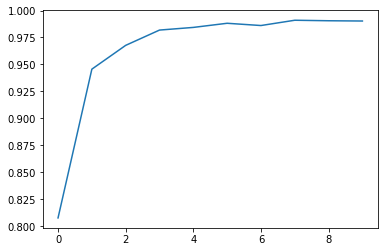

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])

In [0]:
# Test the architecture
xb, yb = next(gen_sequences(1))

In [45]:
tf.argmax(xb[0], axis=2)

<tf.Tensor: id=2190909, shape=(1, 10), dtype=int64, numpy=array([[4, 1, 1, 4, 1, 3, 2, 3, 3, 0]])>

In [46]:
tf.argmax(model.predict(xb), axis=2)

<tf.Tensor: id=2193052, shape=(1, 10), dtype=int64, numpy=array([[0, 1, 1, 1, 2, 3, 3, 3, 4, 4]])>

In [47]:
xb[0].shape

TensorShape([1, 10, 5])

In [0]:
# TODO: replicate the evaluation, without teacher forcing